# 手写数字识别_LeNet

In [1]:
# 引入库
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import os

In [7]:
# 加载训练数据集
train_dataset = torchvision.datasets.MNIST("../dataset", train=True, transform=torchvision.transforms.ToTensor(), download=True)
# 加载测试数据集
test_dataset = torchvision.datasets.MNIST("../dataset", train=False, transform=torchvision.transforms.ToTensor(), download=True)
# 打印训练数据集长度
train_dataset_size = len(train_dataset)
print(train_dataset)
# 打印测试数据集长度
test_dataset_size = len(test_dataset)
print(test_dataset)

# 使用DataLoader加载训练数据
train_dataloader = DataLoader(train_dataset, batch_size=50)
# 使用DataLoader加载测试数据
test_dataloader = DataLoader(test_dataset, batch_size=50)

# 遍历数据集
for data in train_dataloader:
    imgs, labels = data
    # 将数据转换为cuda类型
    if torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../dataset
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../dataset
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
# 定义LeNet-5模型
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
        
    def forward(self, input):
        output = self.model(input)
        return output

# 实例化神经网络
model = LeNet5()
# 加载现有的网络
# module = torch.load("net_CIFAR10.pth")

# 将神经网络转换为cuda类型
if torch.cuda.is_available():
    model = model.cuda()
# 打印神经网络信息
print("神经网络信息")
print(model)

# 测试神经网络的输出格式
# 设置满足要求的输入
input = torch.ones([1, 1, 28, 28])
print("输入数据格式", input.shape)
# 将输入数据络转换为cuda类型
if torch.cuda.is_available():
    input = input.cuda()

output = model(input)
print("输出数据格式", output.shape)

# 查看神经网络模型大小
summary(model, input_size = [[1, 28, 28]])

神经网络信息
LeNet5(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=256, out_features=120, bias=True)
    (6): ReLU()
    (7): Linear(in_features=120, out_features=84, bias=True)
    (8): ReLU()
    (9): Linear(in_features=84, out_features=10, bias=True)
  )
)
输入数据格式 torch.Size([1, 1, 28, 28])
输出数据格式 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [

In [4]:
# 设置神经网络超参数
# 设置损失函数
loss_fn = nn.CrossEntropyLoss()
# 将损失函数转换为cuda类型
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()
# 设置优化器
learning_rate = 0.0001 # 设置学习率
lambda_val = 0.01 # 设置正则化系数Lambda
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_val)

In [40]:
# 加载之前训练的网络
# module = torch.load("module save/history save/moduel save acc.pth")

# 总训练次数
train_step = 0
# 设定训练轮数
epoch = 10
# 定义训练集loss以及准确率变量
loss_train = 0.0
loss_train_sum = 0.0
loss_train_mean = 0.0
loss_train_store = np.zeros(epoch)
accuracy_train = 0
accuracy_rate_train = 0.0
accuracy_rate_train_store = np.zeros(epoch)
# 定义交叉验证集loss以及准确率变量
loss_cv = 0.0
loss_cv_sum = 0.0
loss_cv_mean = 0.0
loss_cv_store = np.zeros(epoch)
accuracy_cv = 0
accuracy_rate_cv = 0.0
accuracy_rate_cv_store = np.zeros(epoch)

# 开始训练
# T1 = time.time()
for i in range(epoch):
    print("-----------第%d轮训练开始------------" %i)
    # 每轮loss累加值清零
    loss_train_sum = 0
    loss_cv_sum = 0
    # 开始训练神经网络
    model.train()
    for data in train_dataloader:
        imgs, labels = data
        # 将数据转换为cuda类型
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        # 输入神经网络并运行
        output = model(imgs)
        
        # 计算损失函数
        loss_train = loss_fn(output, labels)
        # 累加损失函数
        loss_train_sum += loss_train.item()
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 累加计算结果准确性
        accuracy_train += (pred_label == labels).sum()
        # 清零优化器的累计梯度
        optim.zero_grad()
        # 计算梯度
        loss_train.backward()
        # 优化器开始优化
        optim.step()

    # 计算训练集损失函数loss train
    loss_train_mean = loss_train_sum / (len(train_dataset)/train_dataloader.batch_size)
    loss_train_store[i] = loss_train_mean
    # 计算训练集准确率
    accuracy_rate_train = (accuracy_train/train_dataset_size) * 100
    accuracy_rate_train_store[i] = accuracy_rate_train
    
    
    # 开始测试神经网络
    model.eval()
    # 总测试次数
    test_step = 0
    # 准确性变量清零
    accuracy_train = 0
    accuracy_cv = 0
    with torch.no_grad(): # 预测阶段不进行梯度下降
        for data in test_dataloader:
            imgs, labels = data
            # 将数据转换为cuda类型
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            # 输入神经网络并运行
            output = model(imgs)
            # 计算损失函数
            loss_cv = loss_fn(output, labels)
            # 累加损失函数
            loss_cv_sum += loss_cv.item()
            # 将分类概率转化为对应标签
            pred_label = output.argmax(1)
            # 累加计算结果准确性
            accuracy_cv += (pred_label == labels).sum()
            test_step += 1

    # 计算交叉验证集损失函数loss cv
    loss_cv_mean = loss_cv_sum / (len(test_dataset)/test_dataloader.batch_size)
    loss_cv_store[i] = loss_cv_mean
    # 计算交叉验证集准确率
    accuracy_rate_cv = (accuracy_cv/test_dataset_size) * 100
    accuracy_rate_cv_store[i] = accuracy_rate_cv
    # 输出该轮训练结果
    print("loss train: %.5f, accuracy rate train: %.5f%%, loss cv: %.5f, accuracy rate cv: %.5f%%" %(loss_train_mean, accuracy_rate_train.item(), loss_cv_mean, accuracy_rate_cv.item()))
    # 保存神经网络模型
    torch.save(model, "module save/auto save/module auto save %d.pth" %i)

# 结束训练
# T2 = time.time()
# print("使用GPU训练总时长为%s秒" % (T2 - T1))
print("---------训练完成---------")

-----------第0轮训练开始------------
loss train: 0.08913, accuracy rate train: 97.57000%, loss cv: 0.07949, accuracy rate cv: 97.81999%
-----------第1轮训练开始------------
loss train: 0.08733, accuracy rate train: 97.60333%, loss cv: 0.07935, accuracy rate cv: 97.85999%
-----------第2轮训练开始------------
loss train: 0.08661, accuracy rate train: 97.64000%, loss cv: 0.07904, accuracy rate cv: 97.85000%
-----------第3轮训练开始------------
loss train: 0.08601, accuracy rate train: 97.65166%, loss cv: 0.07873, accuracy rate cv: 97.85000%
-----------第4轮训练开始------------
loss train: 0.08554, accuracy rate train: 97.66500%, loss cv: 0.07849, accuracy rate cv: 97.84000%
-----------第5轮训练开始------------
loss train: 0.08516, accuracy rate train: 97.68166%, loss cv: 0.07826, accuracy rate cv: 97.81999%
-----------第6轮训练开始------------
loss train: 0.08481, accuracy rate train: 97.69667%, loss cv: 0.07805, accuracy rate cv: 97.81999%
-----------第7轮训练开始------------
loss train: 0.08450, accuracy rate train: 97.70834%, loss c

---------损失函数Loss随训练轮数epoch的变化图像---------


---------准确率accuracy随训练轮数epoch的变化图像---------


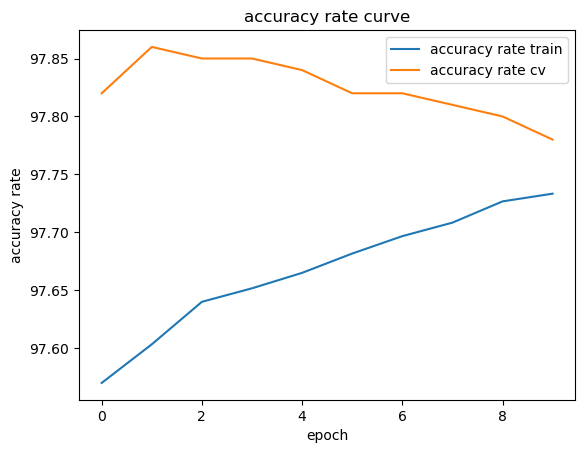

In [41]:
# 画出loss曲线
print("---------损失函数Loss随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), loss_train_store, np.arange(epoch), loss_cv_store)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss train", "loss cv"])
plt.title("loss curve")
plt.show()

# 画出accuracy曲线
print("---------准确率accuracy随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), accuracy_rate_train_store, np.arange(epoch), accuracy_rate_cv_store)
plt.xlabel("epoch")
plt.ylabel("accuracy rate")
plt.legend(["accuracy rate train", "accuracy rate cv"])
plt.title("accuracy rate curve")
plt.show()

In [5]:
# 加载某一轮训练的模型进行预测
# module = torch.load("module save/auto save/module auto save 99.pth")
module = torch.load("module save/history save/module save acc97.pth")

# 开始使用神经网络预测
module.eval()
# 总测试次数
test_step = 0
# 统计准确性
accuracy = 0
with torch.no_grad(): # 预测阶段不进行梯度下降
    for data in test_dataloader:
        imgs, labels = data
        # 将数据转换为cuda类型
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        # 输入神经网络并运行
        output = module(imgs)
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 每1次输出结果
        if (test_step%100==0):
            print("输出结果", pred_label)
            print("原始标签", labels)
        # 累加计算结果准确性
        accuracy += (pred_label == labels).sum()
        test_step += 1

accuracy_rate = accuracy/test_dataset_size
print("模型预测正确数", accuracy.item(), "模型测试总数", test_dataset_size)
print("模型预测准确率: %.2f%%" %(accuracy_rate.item()*100))

输出结果 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4], device='cuda:0')
原始标签 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4], device='cuda:0')
输出结果 tensor([3, 9, 9, 8, 4, 1, 0, 6, 0, 9, 6, 8, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4,
        2, 1, 9, 4, 3, 9, 6, 0, 4, 0, 6, 0, 1, 2, 3, 4, 7, 8, 9, 0, 1, 2, 3, 4,
        7, 8], device='cuda:0')
原始标签 tensor([3, 9, 9, 8, 4, 1, 0, 6, 0, 9, 6, 8, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4,
        2, 1, 9, 4, 3, 9, 6, 0, 4, 0, 6, 0, 1, 2, 3, 4, 7, 8, 9, 0, 1, 2, 3, 4,
        7, 8], device='cuda:0')
模型预测正确数 9778 模型测试总数 10000
模型预测准确率: 97.78%


In [8]:
# 取出单张图片进行预测

# 加载某一轮训练的模型进行预测
# module = torch.load("module save/auto save/module auto save 99.pth")
module = torch.load("module save/history save/module save acc97.pth")

# 载入原始数据
# 加载测试集中的单张图片
index = 150
img, label = test_dataset[index]
print(img)
img = torchvision.transforms.ToPILImage()(img)
plt.imshow(img)
print("原始图像")
plt.show()
# 使用DataLoader加载数据
img, label = DataLoader(test_dataset[index], batch_size=1)
# 将数据转换为cuda类型
if torch.cuda.is_available():
    img = img.cuda()
    label = label.cuda()

# 加载外部的单张图片
# img_path = "../dataset/image.jpg"
# # 使用transform对图像进行压缩等变化
# img = Image.open(img_path) # torchvision必须使用PIL打开图片，不能直接使用plt的格式
# transform = torchvision.transforms.Compose([torchvision.transforms.Resize([32, 32]),
#                                            torchvision.transforms.ToTensor()])
# img = transform(img)
# # 转换为PIL类型查看处理后的图像
# img_trans = torchvision.transforms.ToPILImage()(img)
# plt.imshow(img_trans)
# print("输入图像")
# plt.show()
# img = torch.reshape(img, [1, 1, 32, 32])
# # 将数据转换为cuda类型
# if torch.cuda.is_available():
#     img = img.cuda()


# 开始使用神经网络预测
module.eval()
with torch.no_grad(): # 推理阶段不进行梯度下降
    # 输入进入神经网络进行预测
    output = module(img)
    # 将分类概率转化为对应标签
    pred_label = output.argmax(1)

# 输出结果
# 查看原始数据并显示
label_list = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
# print("原始正确标签", label_list[label.item()])
print("模型预测结果是:", label_list[pred_label.item()])
print("输出各结果的概率分别是:", output)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

模型预测结果是: 9
输出各结果的概率分别是: tensor([[-2.7542, -5.7895, -4.1541,  0.7298,  1.7505,  1.8968, -6.0092,  0.6809,
          1.7759,  9.8131]], device='cuda:0')


In [42]:
# 保存神经网络模型
# torch.save(module, "module save/history save/module save acc.pth")
print("模型已保存")

模型已保存


In [45]:
# 查看网络参数
# 加载某一轮训练的模型进行预测
# module = torch.load("module save/auto save/module auto save 99.pth")
module = torch.load("module save/history save/module save acc97.pth")

print(module)
torch.set_printoptions(threshold=np.inf) # 输出的参数数量不限制
module.named_parameters()
for name, param in module.named_parameters(prefix="LeNet"):
    print(name, param)
    print(name, param.size())

# print(net_AlexNet.state_dict().keys())
# print(net_AlexNet.state_dict())

LeNet5(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=256, out_features=120, bias=True)
    (6): ReLU()
    (7): Linear(in_features=120, out_features=84, bias=True)
    (8): ReLU()
    (9): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNet.model.0.weight Parameter containing:
tensor([[[[-0.1623, -0.1654, -0.0851,  0.0988,  0.2701],
          [-0.2013, -0.1890, -0.0990,  0.1554,  0.3188],
          [-0.2303, -0.1868, -0.0723,  0.2372,  0.3390],
          [-0.2077, -0.1407,  0.0190,  0.2481,  0.2968],
          [-0.1437, -0.0351,  0.1083,  0.2675,  0.2603]]],


        [[[-0.1309, -0.2841, -0.3067, -0.2893, -0.2746],
          [-0.0115, -0.2421, -0.29

In [47]:
# 打印模型到txt中


In [33]:
# 清除显存
torch.cuda.empty_cache()